## Homework [DRAFT]

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

Solution: [homework.ipynb](homework.ipynb)

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- **`duration`**
- `previous`


In [1]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip bank+marketing.zip 
!unzip bank.zip

In [2]:
import pandas as pd

df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df = df.drop(['default', 'loan'], axis=1)

In [4]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
# Check if the missing values are present in the features:
df.isnull().values.any()

np.False_

In [6]:
names = df.columns # List of column names
for name in names:
    df.copy()
    length = len(df[name].value_counts()) # Access values from actual df
    print(f"{name}: {length}")

age: 77
job: 12
marital: 3
education: 4
balance: 7168
housing: 2
contact: 3
day: 31
month: 12
duration: 1573
campaign: 48
pdays: 559
previous: 41
poutcome: 4
y: 2


In [7]:
df.pdays.value_counts()

pdays
-1      36954
 182      167
 92       147
 183      126
 91       126
        ...  
 749        1
 769        1
 587        1
 778        1
 854        1
Name: count, Length: 559, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [11]:
type(df_train)

pandas.core.frame.DataFrame

In [12]:
from sklearn.metrics import roc_auc_score

columns = df_train[['balance', 'day', 'duration', 'previous']].copy()
target = df_train['y'].copy()

for column in columns.columns:  # Iterate over column names data
    auc = roc_auc_score(target, columns[column])  # Use columns[column] for the data
    # If the auc is negative, invert the variable and recalculate
    if auc < 0.5:
        columns[column] = -columns[column]  # Directly modify the column
        auc = roc_auc_score(target, columns[column])
    print(f"{column}: {auc}")         

balance: 0.590061489160812
day: 0.5265199356555834
duration: 0.8075955951124923
previous: 0.6023034054239005


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- **0.89**
- 0.99

In [13]:
df_train['y'] = df_train['y'].map({'yes': 1, 'no': 0})
df_val['y'] = df_val['y'].map({'yes': 1, 'no': 0})
df_test['y'] = df_test['y'].map({'yes': 1, 'no': 0})

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [14]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np

# Identify categorical and numerical features
cat_cols = df_train.dtypes[df_train.dtypes == 'object'].index
num_cols = df_train.dtypes[df_train.dtypes == 'int64'].index

# Initialize DictVectorizer and StandardScaler
dv = DictVectorizer(sparse=False)
scaler = StandardScaler()

# One-hot-encode categorical features
train_dict = df_train[cat_cols].to_dict(orient='records')
val_dict = df_val[cat_cols].to_dict(orient='records')

X_train_cat = dv.fit_transform(train_dict)
X_val_cat = dv.transform(val_dict)

# Scale numerical features
X_train_num = scaler.fit_transform(df_train[num_cols])
X_val_num = scaler.transform(df_val[num_cols])

# Combine categorical and numerical features
X_train = np.hstack([X_train_cat, X_train_num]) # -> np.concatenate([a, b], axis=1)
X_val = np.hstack([X_val_cat, X_val_num])

In [15]:
type(X_train_cat)

numpy.ndarray

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [17]:
# Use predict_proba for the probability of each class (e.g., for ROC AUC or threshold-based)
y_pred = model.predict_proba(X_val)[:, 1] # Probability of class 1 (subscribed to a term deposit)
term_deposit_decision = (y_pred >= 0.5)
round((y_val == term_deposit_decision).mean(), 3)

np.float64(0.902)

In [18]:
print(model.classes_), type(y_pred)

[0 1]


(None, numpy.ndarray)

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* **0.265**
* 0.465
* 0.665
* 0.865

In [19]:
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Define thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Store precision and recall for each threshold
precision = []
recall = []

# Compute precision and recall for each threshold
for t in thresholds:
    # If threshold is lower than prediction classify it as a positive case
    y_pred_class = (y_pred >= t)
    
    # Calculate precision and recall
    # Below can be calculated with:
    #    p = precision_score(y_val, y_pred_class.astype(int), zero_division=0)
    #    r = recall_score(y_val, y_pred_class.astype(int), zero_division=0)
    tp = ((y_pred_class == 1) & (y_val == 1)).sum()  # Predicted positive and actually positive
    fp = ((y_pred_class == 1) & (y_val == 0)).sum()  # Predicted positive but actually negative
    fn = ((y_pred_class == 0) & (y_val == 1)).sum()  # Predicted negative but actually positive
    
    # Handle division by zero
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0 
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0 
    
    # Append results
    precision.append(p)
    recall.append(r)

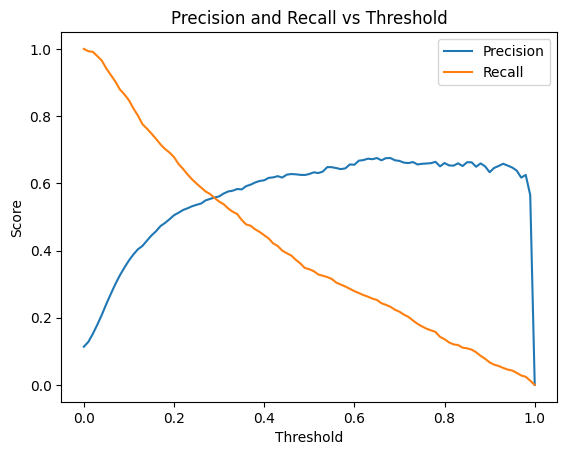

In [20]:
# Plot precision and recall curves
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, recall, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision and Recall vs Threshold")
plt.show()

In [21]:
# Find the threshold where precision equals recall
precision = np.array(precision)  # Convert to NumPy arrays for vectorized operations
recall = np.array(recall)

# Calculate the absolute difference between precision and recall, excluding cases where both are zero
diff = np.where((precision == 0.0) & (recall == 0.0), np.inf, np.abs(precision - recall)) # np.where(condition, value_if_true, value_if_false)

# Find the index of the minimum difference
min_diff_index = np.argmin(diff)

# Get the corresponding threshold
threshold_equal = thresholds[min_diff_index]
print(f"Threshold where precision equals recall: {threshold_equal:.3f}")

Threshold where precision equals recall: 0.290


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- **0.22**
- 0.42
- 0.62

In [22]:
# Define thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Store F1 for each threshold
F_1 = []

# Compute precision and recall for each threshold
for t in thresholds:
    # If threshold is lower than prediction classify it as a positive case
    y_pred_class = (y_pred >= t)
    
    # Calculate precision and recall
    # Below can be calculated with:
    #    p = precision_score(y_val, y_pred_class.astype(int), zero_division=0)
    #    r = recall_score(y_val, y_pred_class.astype(int), zero_division=0)
    tp = ((y_pred_class == 1) & (y_val == 1)).sum()  # Predicted positive and actually positive
    fp = ((y_pred_class == 1) & (y_val == 0)).sum()  # Predicted positive but actually negative
    fn = ((y_pred_class == 0) & (y_val == 1)).sum()  # Predicted negative but actually positive
    
    # Handle division by zero
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0 
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0 
    
    score = 2 * ((p * r) / (p + r)) if (p + r) > 0 else 0.0
    # Append results
    F_1.append(score)
    
# Get the index of the maximum F1 score
max_f1_index = np.argmax(F_1)

# Print the index and the corresponding threshold
print(f"Index of max F1: {max_f1_index}")
print(f"Threshold at max F1: {thresholds[max_f1_index]}")
print(f"Maximal F1: {round(max(F_1), 2)}") 

Index of max F1: 20
Threshold at max F1: 0.2
Maximal F1: 0.58


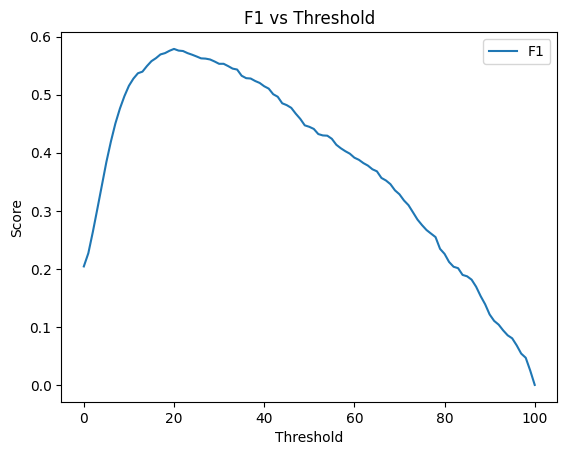

In [23]:
# Plot F1 curves
plt.plot(F_1, label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("F1 vs Threshold")
plt.show()

### Question 5: 5-Fold CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- **0.006**
- 0.06
- 0.26

In [28]:
from sklearn.model_selection import KFold

# Concatenate training and validation data
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])

# Set up K-Fold cross-validation
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

# Train and evaluate the model for each fold
for train_idx, val_idx in kfold.split(df_full_train):
    # Split data into training and validation subsets
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    # Identify categorical and numerical features
    cat_cols = df_train.dtypes[df_train.dtypes == 'object'].index
    num_cols = df_train.dtypes[df_train.dtypes == 'int64'].index

    # Initialize DictVectorizer and StandardScaler
    dv = DictVectorizer(sparse=False)
    scaler = StandardScaler()

    # One-hot-encode categorical features
    train_dict = df_train[cat_cols].to_dict(orient='records')
    val_dict = df_val[cat_cols].to_dict(orient='records')

    X_train_cat = dv.fit_transform(train_dict)
    X_val_cat = dv.transform(val_dict)

    # Scale numerical features
    X_train_num = scaler.fit_transform(df_train[num_cols])
    X_val_num = scaler.transform(df_val[num_cols])

    # Combine categorical and numerical features
    X_train = np.hstack([X_train_cat, X_train_num])
    X_val = np.hstack([X_val_cat, X_val_num])

    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the validation subset
    y_pred = model.predict_proba(X_val)[:, 1]  # Probability of class 1 (subscribed to a term deposit)

    # Compute AUC score
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print(auc)

0.9010326796090458
0.9013067797651975
0.9055562109752207
0.9094088578731809
0.9106172380302936


In [ ]:
# Print the mean and standard deviation of AUC scores 
print('C=1.0, mean: %.3f, std: +- %.3f' % (np.mean(scores), np.std(scores)))

C=1.0, mean: 0.906, std: +- 0.006


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- **0.001**
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [50]:
# Set up K-Fold cross-validation
n_splits = 5

# Hyperparameter Tuning
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    scores = []
    
    # Train and evaluate the model for each fold
    for train_idx, val_idx in kfold.split(df_full_train):
        # Split data into training and validation subsets
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]
    
        # Identify categorical and numerical features
        cat_cols = df_train.dtypes[df_train.dtypes == 'object'].index
        num_cols = df_train.dtypes[df_train.dtypes == 'int64'].index
    
        # Initialize DictVectorizer and StandardScaler
        dv = DictVectorizer(sparse=False)
        scaler = StandardScaler()
    
        # One-hot-encode categorical features
        train_dict = df_train[cat_cols].to_dict(orient='records')
        val_dict = df_val[cat_cols].to_dict(orient='records')
    
        X_train_cat = dv.fit_transform(train_dict)
        X_val_cat = dv.transform(val_dict)
    
        # Scale numerical features
        X_train_num = scaler.fit_transform(df_train[num_cols])
        X_val_num = scaler.transform(df_val[num_cols])
    
        # Combine categorical and numerical features
        X_train = np.hstack([X_train_cat, X_train_num])
        X_val = np.hstack([X_val_cat, X_val_num])
    
        # Train the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
    
        # Predict on the validation subset
        y_pred = model.predict_proba(X_val)[:, 1]  # Probability of class 1 (subscribed to a term deposit)
    
        # Compute AUC score
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        print(auc)

0.8058786026986324
0.8134108758043849
0.793931323670991
0.8178077889447236
0.8073404211352881
0.885488182050985
0.8878189288736956
0.8876840090710081
0.8970183286374068
0.893398285171114
0.9010326796090458
0.9013067797651975
0.9055562109752207
0.9094088578731809
0.9106172380302936


In [51]:
# Print the mean and standard deviation of AUC scores
print('C=%s, mean: %.3f, std: +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1, mean: 0.906, std: +- 0.004
